In [6]:
from netCDF4 import Dataset
import numpy as np
from advectionGP.sensors import RemoteSensingModel

# Load the NetCDF file
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191001.nc4"
dataset = Dataset(file_path, 'r')
sensors = RemoteSensingModel(num_particles=3)

from pyproj import Proj, Transformer

# Your UTM projection (Zone 56S)
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
proj_wgs84 = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_wgs84)

# Convert all (x, y) to (lon, lat)
sensor_latlons = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    lon, lat = transformer.transform(x, y)
    sensor_latlons.append((lat, lon))

aod_times = dataset.variables['time'][:]
t_index = np.argmin(np.abs(aod_times - t_start))

lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
aod_data = dataset.variables['AODANA'][t_index]  # shape (361, 576)

Y = []
for lat, lon in sensor_latlons:
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))
    value = aod_data[lat_idx, lon_idx]
    Y.append(value)

Y = np.array(Y)
Y = np.nan_to_num(Y, nan=0.0)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y) + 1e-6)


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_35236\3602697078.py:25: RuntimeWarning: invalid value encountered in cast
  aod_times = dataset.variables['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_35236\3602697078.py:25: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = dataset.variables['time'][:]


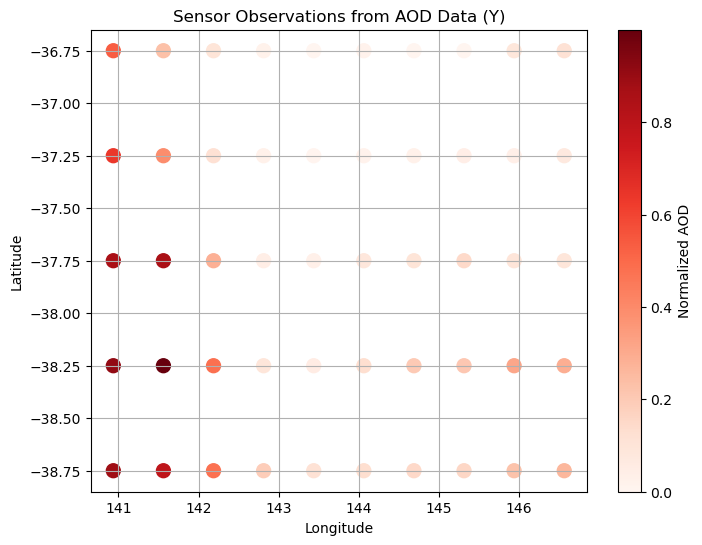

In [7]:
import matplotlib.pyplot as plt

lons_plot = [lon for lat, lon in sensor_latlons]
lats_plot = [lat for lat, lon in sensor_latlons]

plt.figure(figsize=(8, 6))
plt.scatter(lons_plot, lats_plot, c=Y, cmap='Reds', s=100)
plt.colorbar(label='Normalized AOD')
plt.title('Sensor Observations from AOD Data (Y)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


✅ Loaded 8 timestamps with shape (8, 11, 16)
Initialising particles...
Diffusing particles...


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: RuntimeWarning: invalid value encountered in cast
  times = ds.variables['time'][:]
c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  times = ds.variables['time'][:]


[⏱️] Time to computeModelRegressors(): 3.47 seconds
Computing SS...
Inverting SS...


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\840066175.py:95: RuntimeWarning: invalid value encountered in cast
  aod_times = dataset.variables['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\840066175.py:95: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = dataset.variables['time'][:]


Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.40 seconds
Initialising particles...
Particle shape:
(5, 108000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
[⏱️] Time to computeConcentration(): 57.85 seconds
[✅] Total source inference pipeline took 61.72 seconds


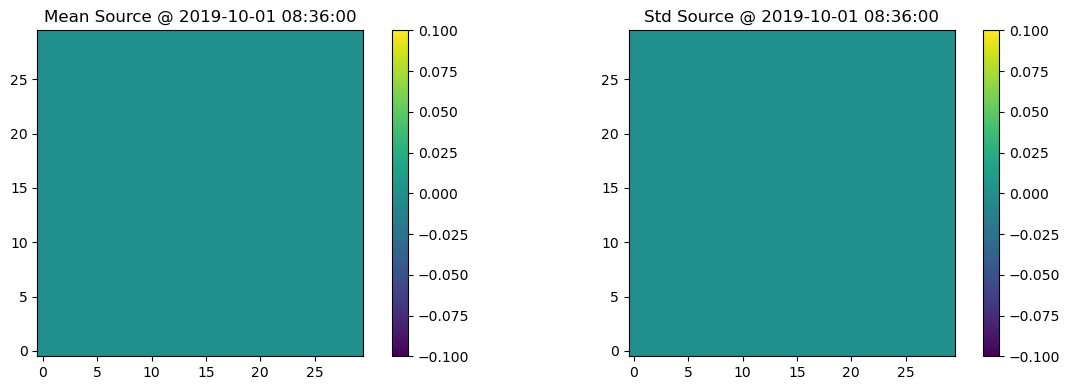

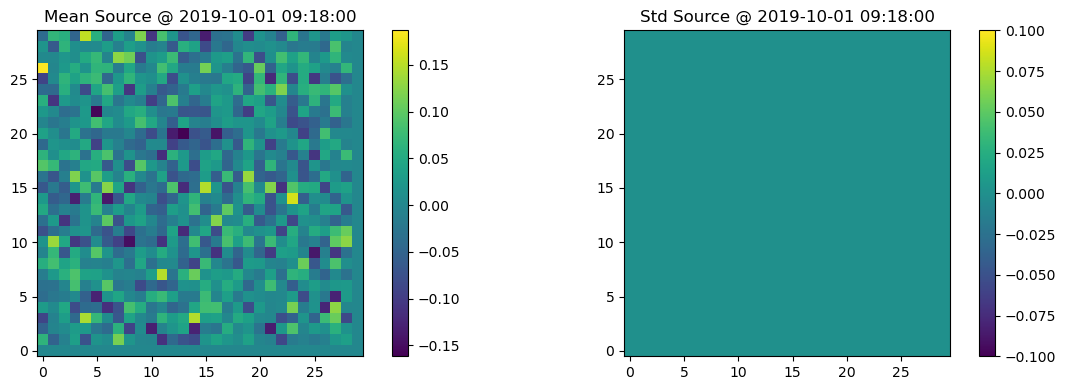

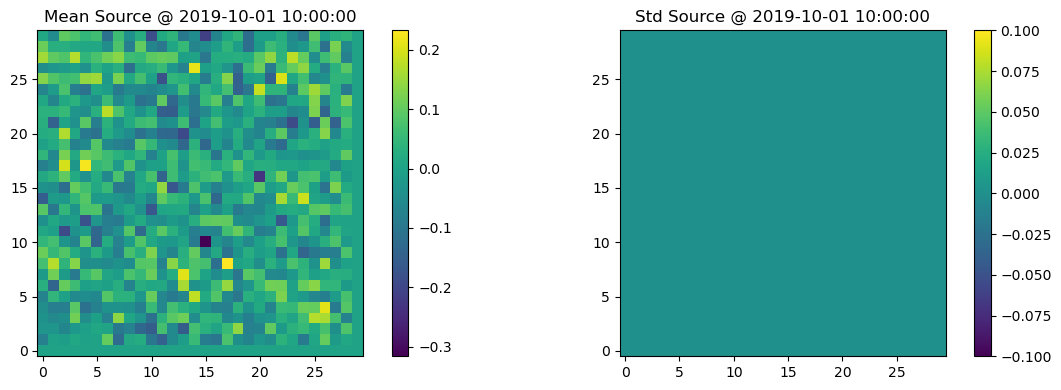

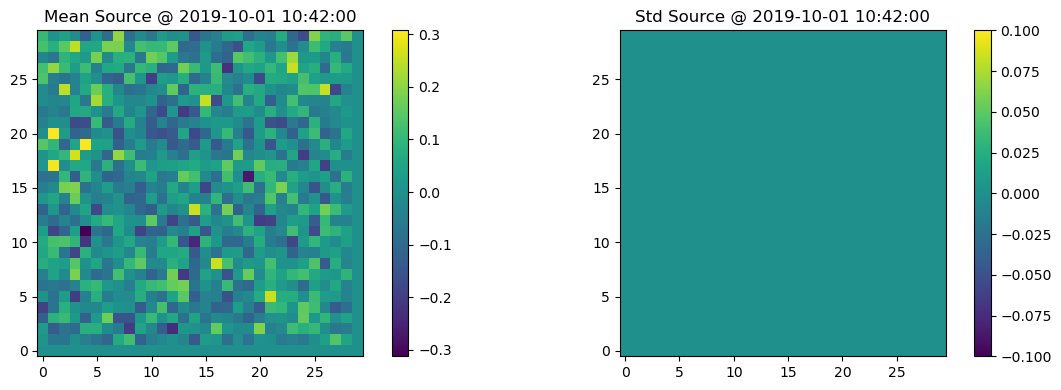

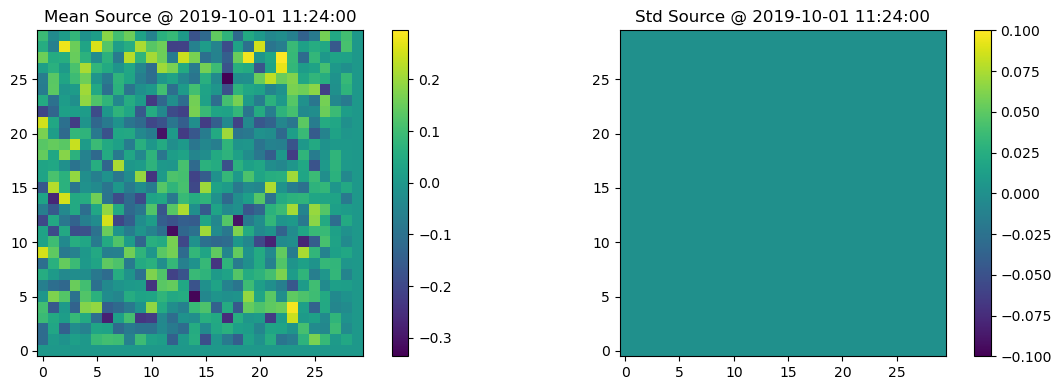

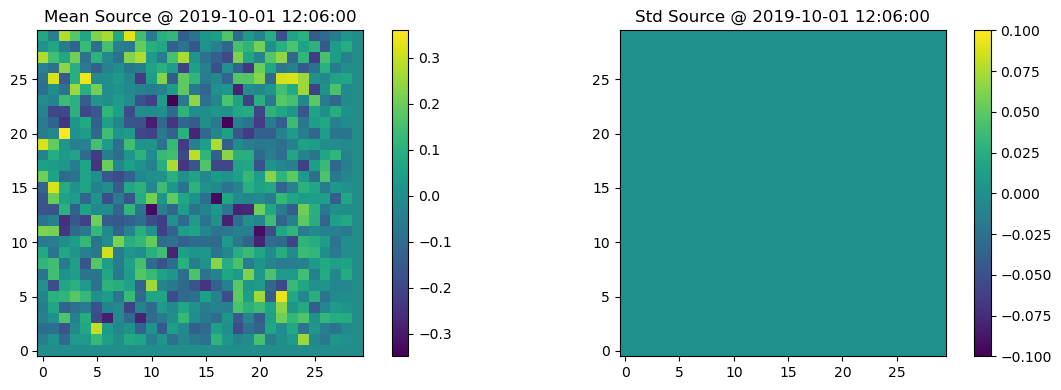

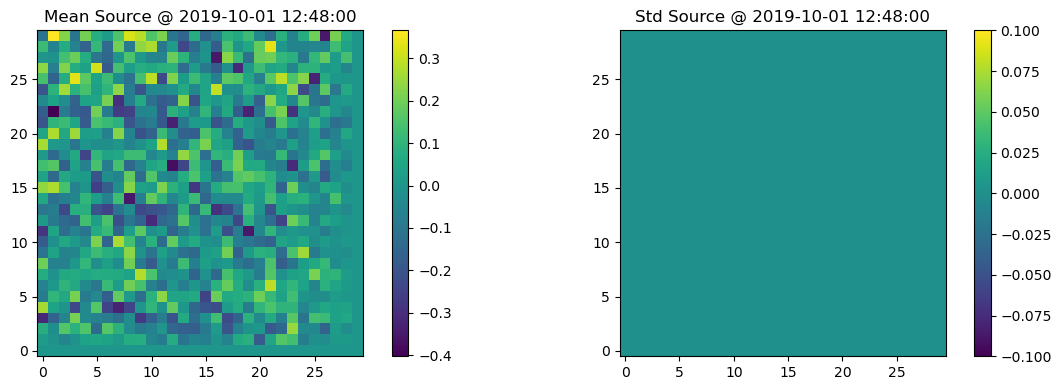

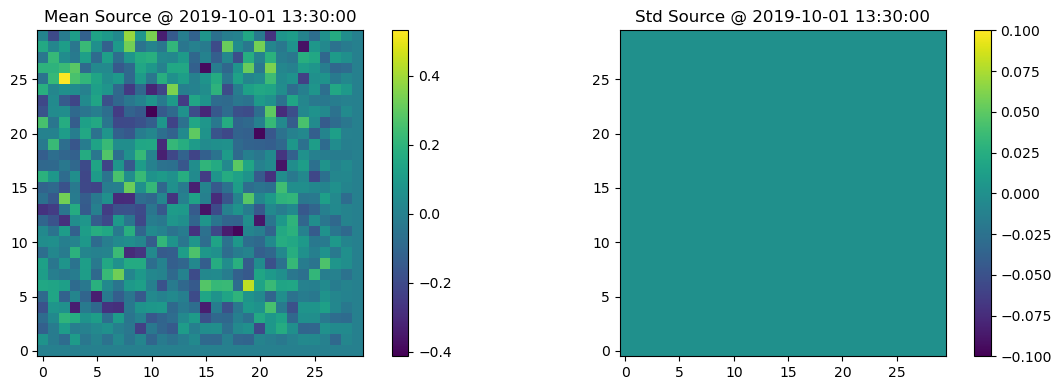

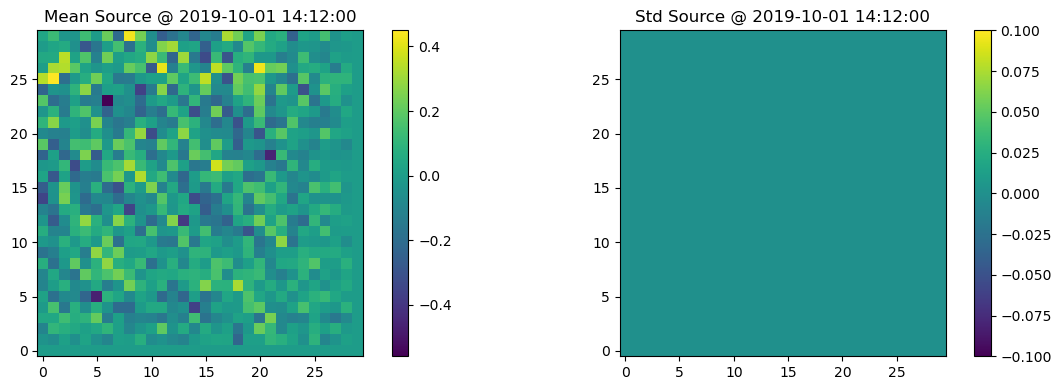

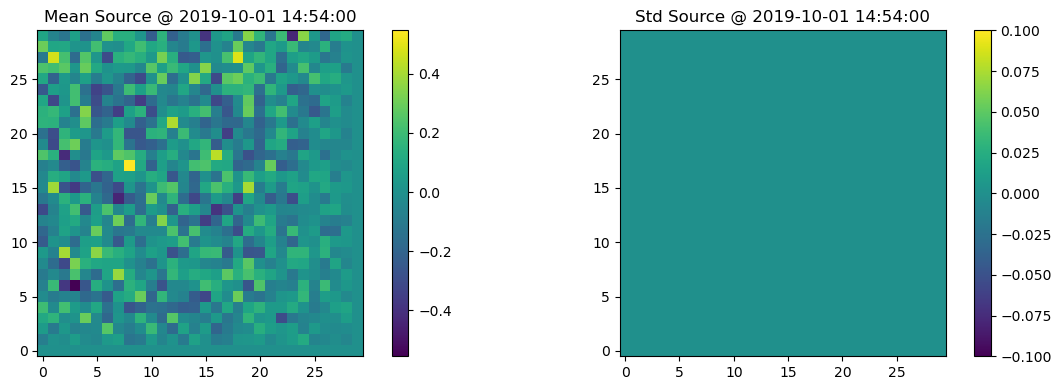

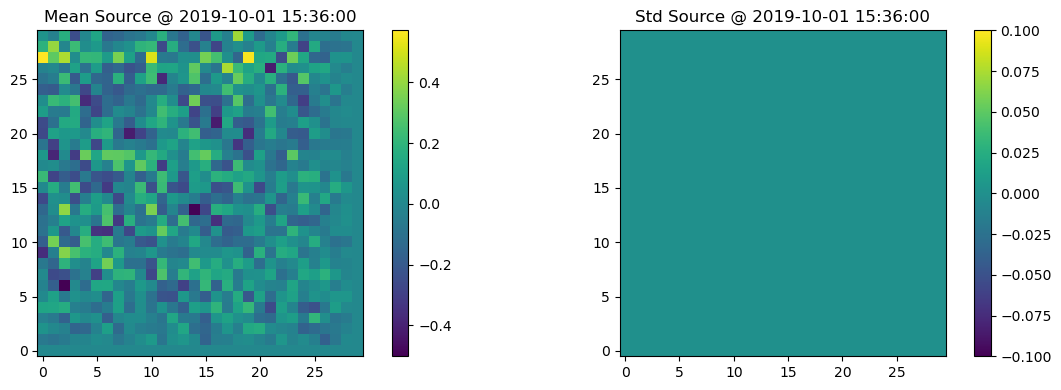

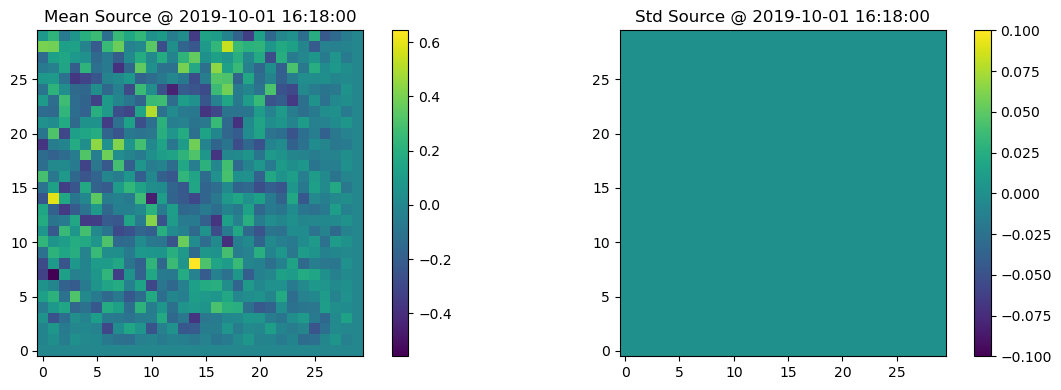

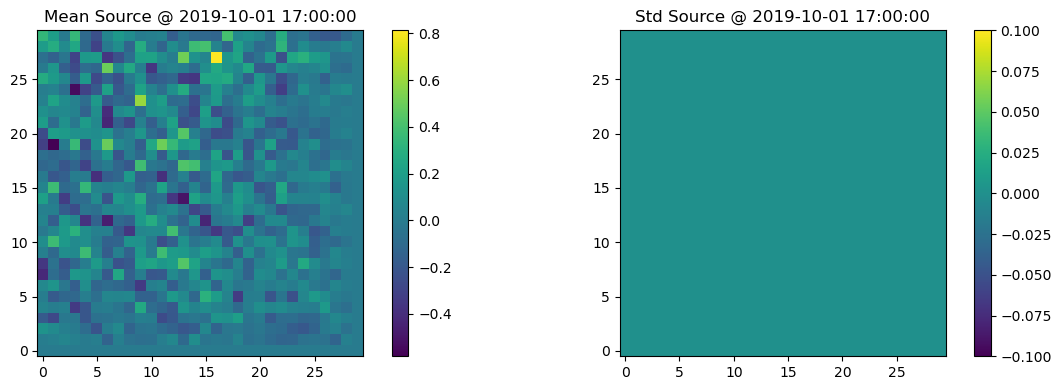

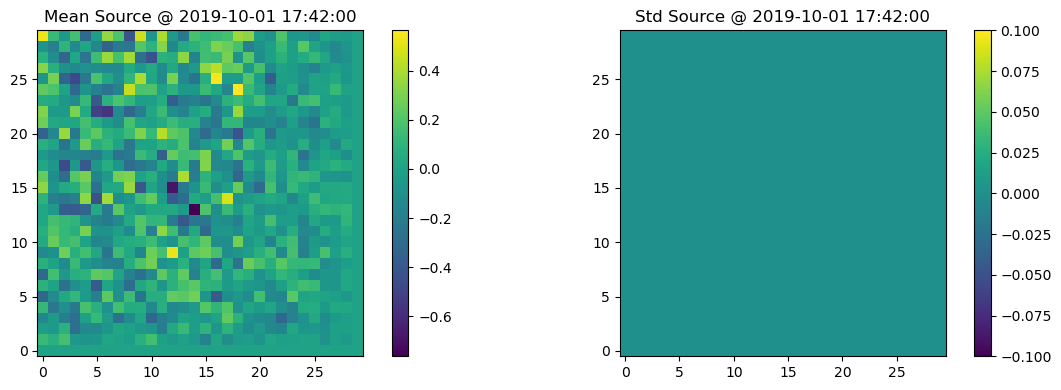

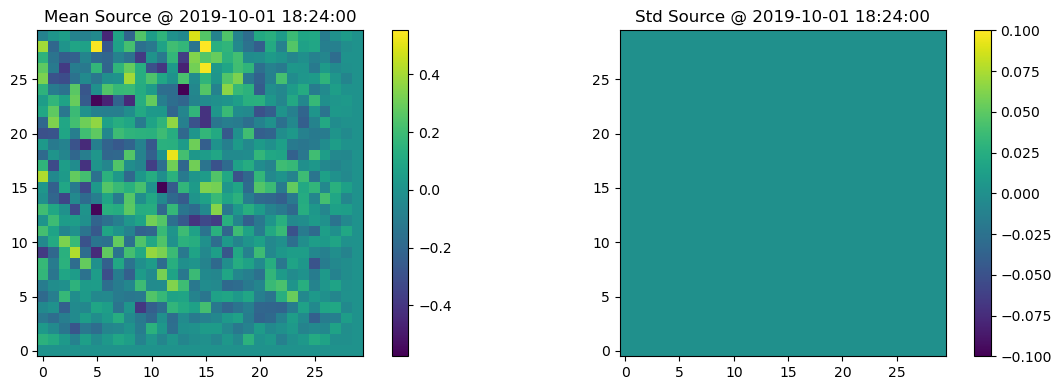

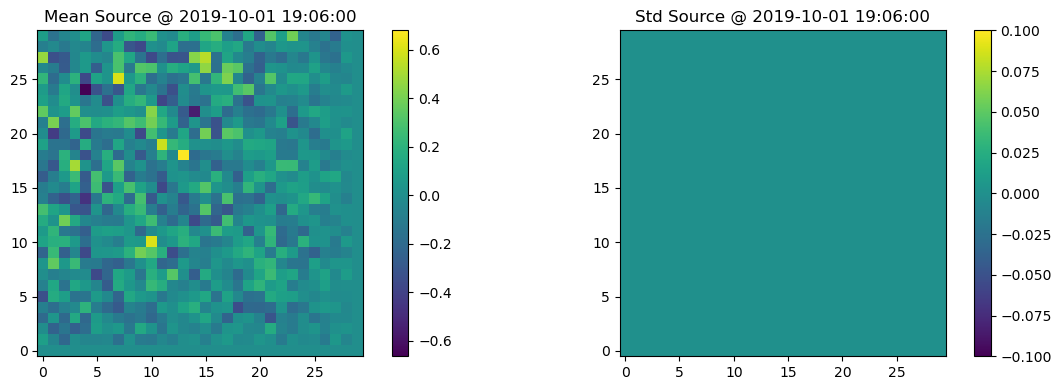

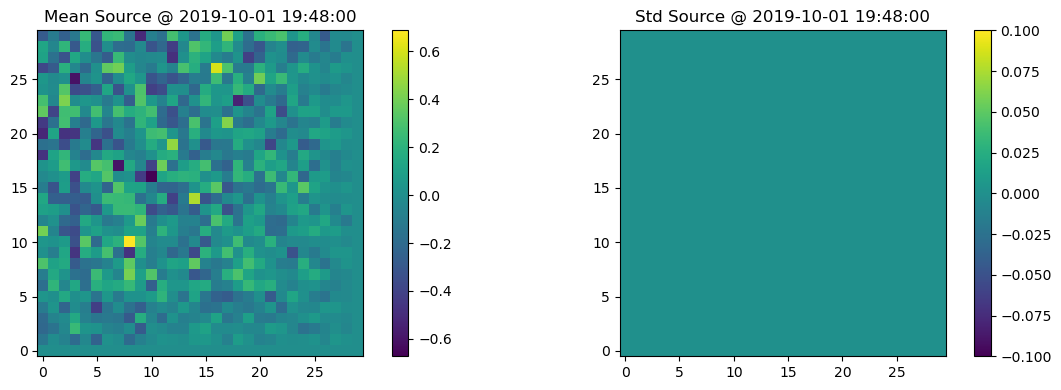

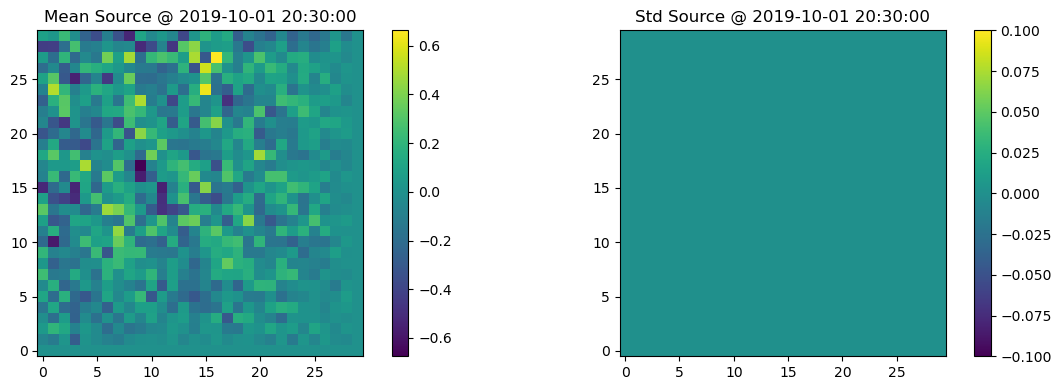

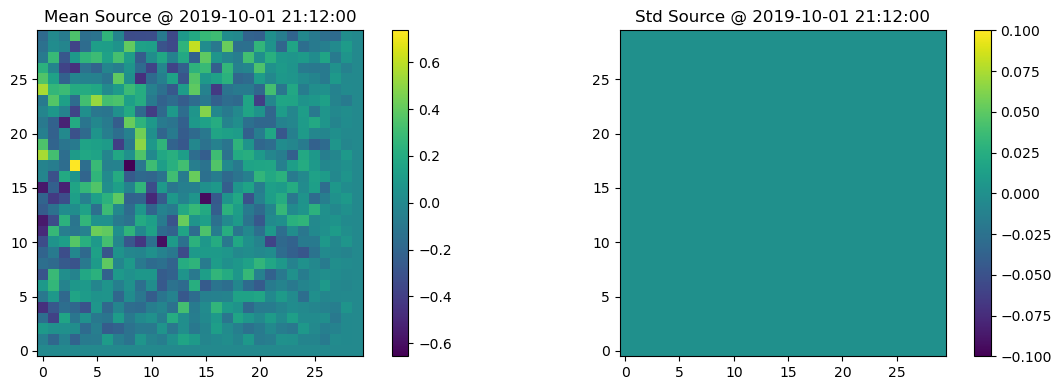

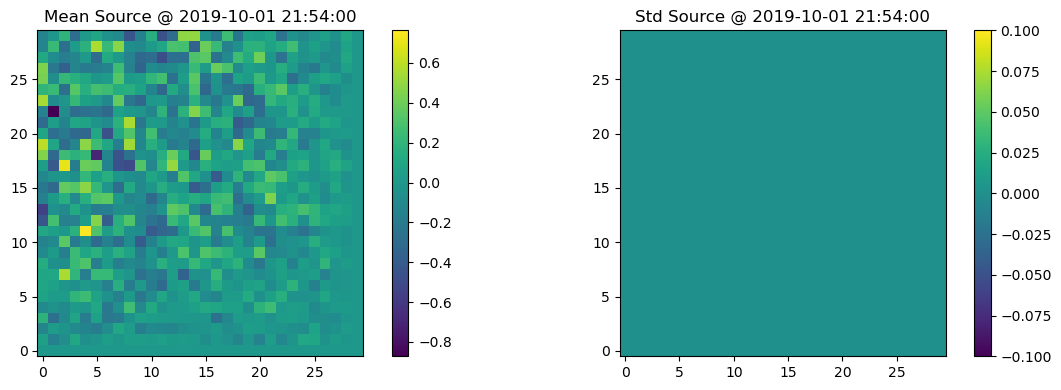

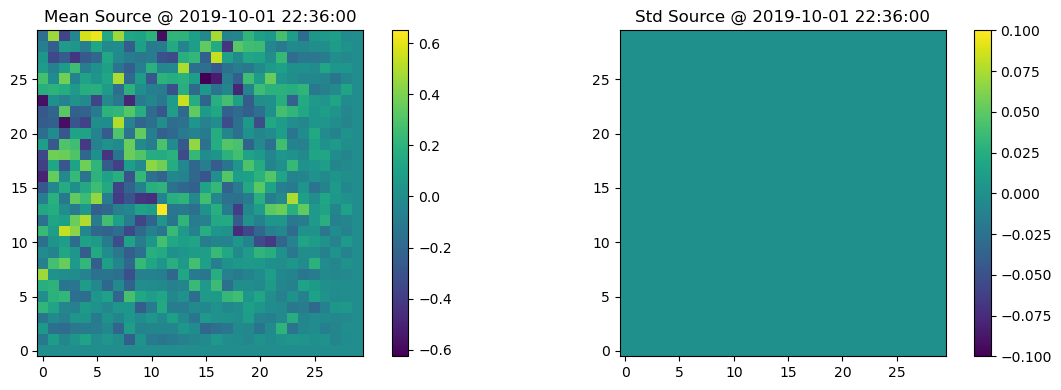

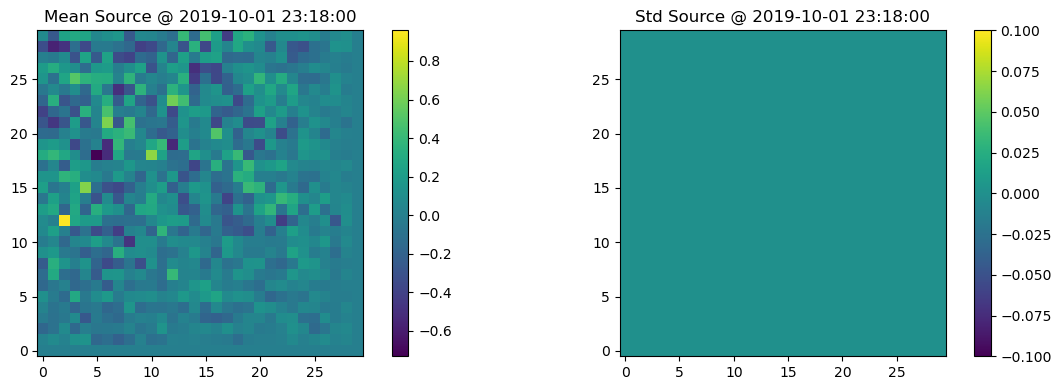

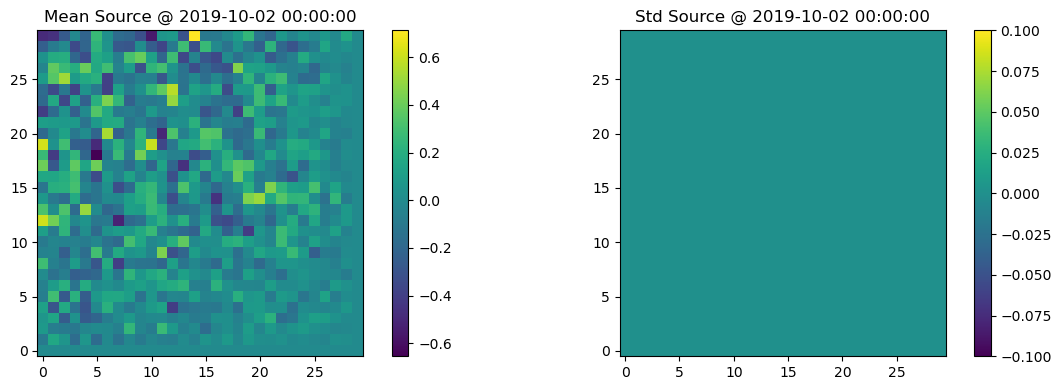

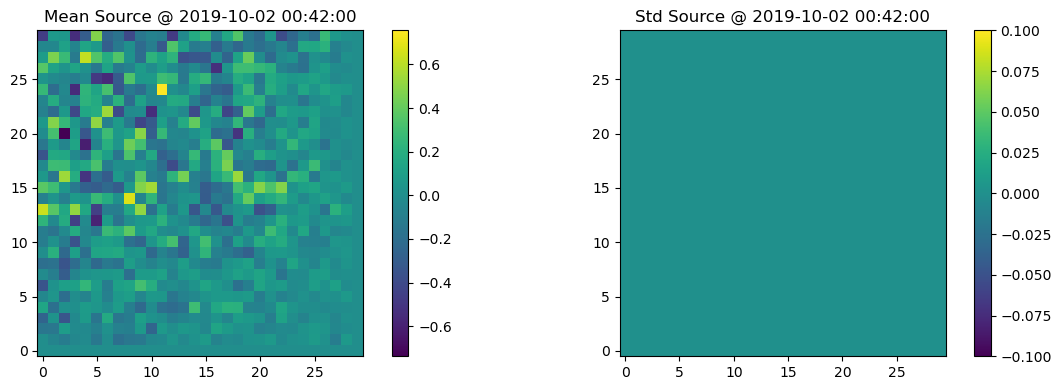

In [10]:
from pyproj import Proj
import numpy as np
from netCDF4 import Dataset
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour, RealWindHybrid, FastWindGrid
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 600, 1440
t_start_sec, t_end_sec = 600 * 60, 1440 * 60 
sensors = RemoteSensingModel(num_particles=3, t_start=t_start_sec, t_end=t_end_sec)

# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start_sec, t_end_sec, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [120, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel4 = FastWindGrid(start_date="2019-10-01", num_days=1)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel4,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
# Load the NetCDF file
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191001.nc4"
dataset = Dataset(file_path, 'r')

from pyproj import Proj, Transformer

# Your UTM projection (Zone 56S)
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
proj_wgs84 = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_wgs84)

# Convert all (x, y) to (lon, lat)
sensor_latlons = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    lon, lat = transformer.transform(x, y)
    sensor_latlons.append((lat, lon))

aod_times = dataset.variables['time'][:]
t_index = np.argmin(np.abs(aod_times - t_start))

lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
aod_data = dataset.variables['AODANA'][t_index]  # shape (361, 576)

Y = []
for lat, lon in sensor_latlons:
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))
    value = aod_data[lat_idx, lon_idx]
    Y.append(value)

Y = np.array(Y)
Y = np.nan_to_num(Y, nan=0.0)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y) + 1e-6)

# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
# Step setup
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
base_time = datetime(2019, 10, 1, 0, 0, 0)  # Adjust to your dataset's base time

# Loop through time steps
for t_index in range(0, res[0], 5):
    real_seconds = boundary[0][0] + t_index * dt_seconds
    real_datetime = base_time + timedelta(seconds=int(real_seconds))
    timestamp_label = real_datetime.strftime("%Y-%m-%d %H:%M:%S")

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ {timestamp_label}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ {timestamp_label}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()



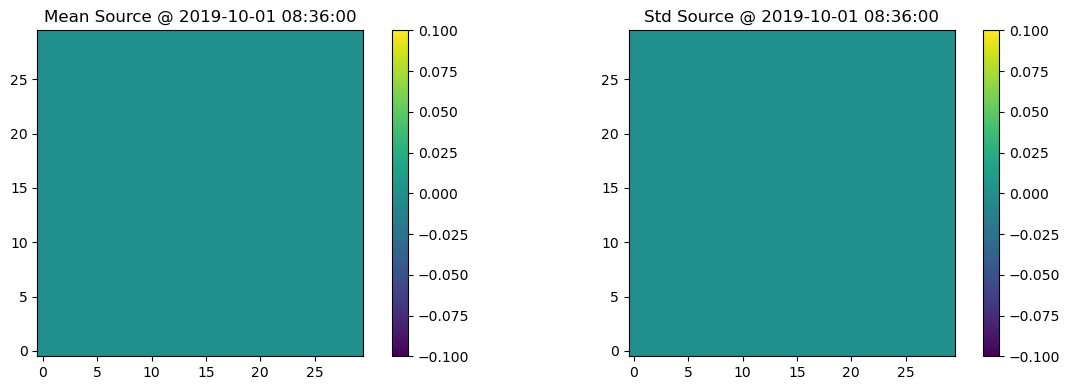

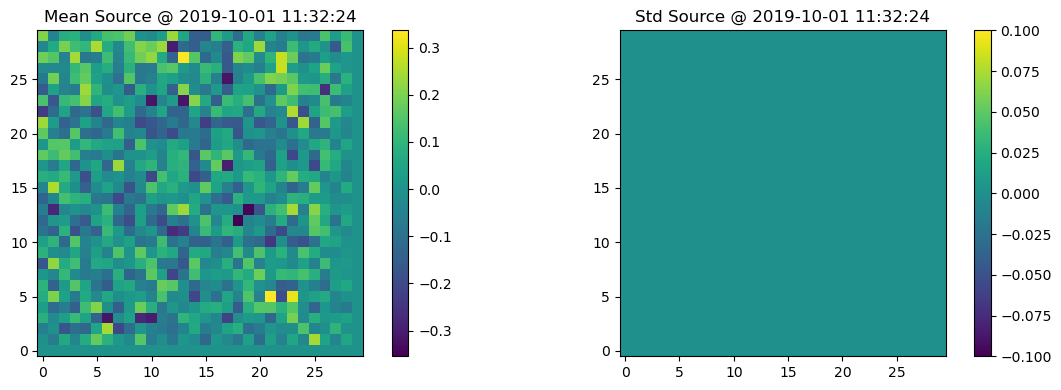

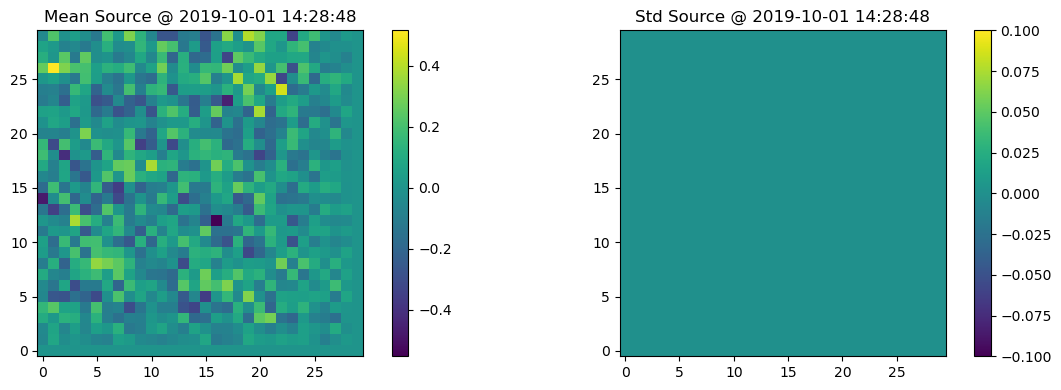

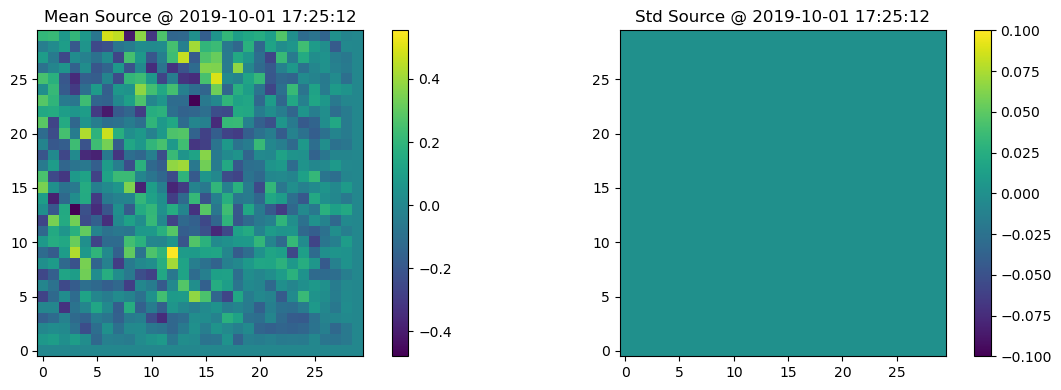

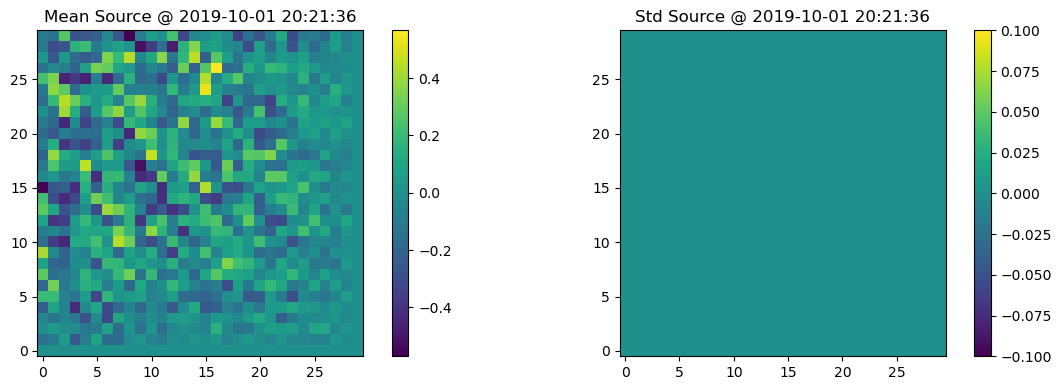

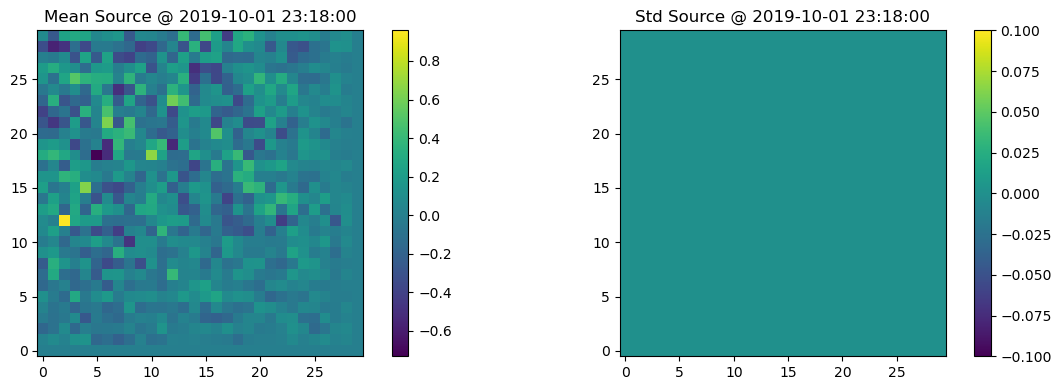

In [11]:
step_interval = int(10800 / dt_seconds)
for t_index in range(0, res[0], step_interval):
    real_seconds = boundary[0][0] + t_index * dt_seconds
    real_datetime = base_time + timedelta(seconds=int(real_seconds))
    timestamp_label = real_datetime.strftime("%Y-%m-%d %H:%M:%S")

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ {timestamp_label}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ {timestamp_label}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

In [12]:
print(f"step_interval = {step_interval}, res[0] = {res[0]}")
print("Boundary start seconds:", boundary[0][0])
print("Start time:", boundary[0][0])
print("End time:", boundary[1][0])
print("X range:", boundary[0][1], "to", boundary[1][1])
print("Y range:", boundary[0][2], "to", boundary[1][2])



step_interval = 21, res[0] = 120
Boundary start seconds: 30960.0
Start time: 30960.0
End time: 91440.0
X range: -680966.0 to 42290.0
Y range: 5563977.0 to 5990697.0


C:\Users\Nur Izfarwiza\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


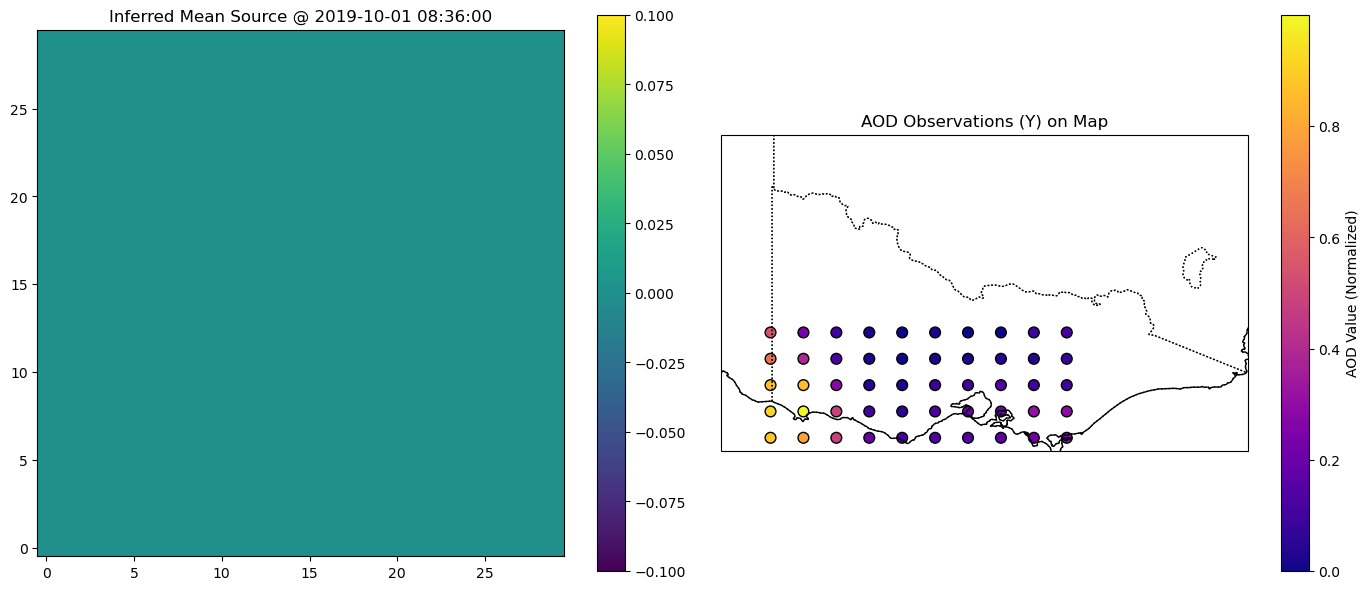

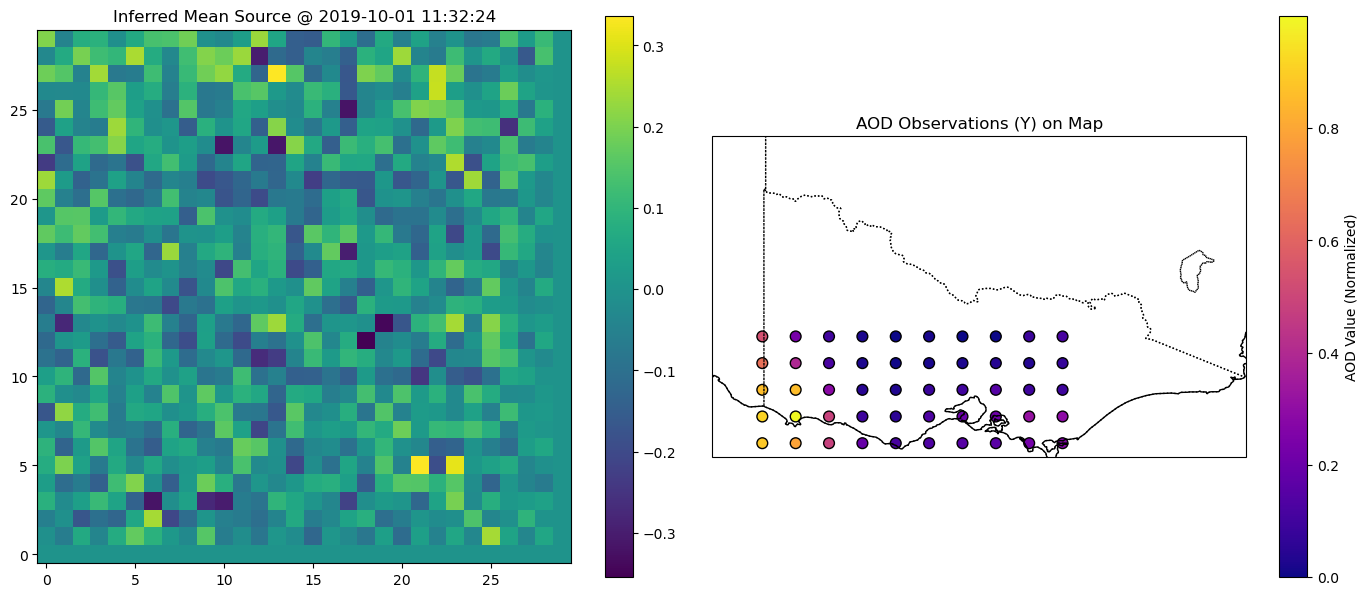

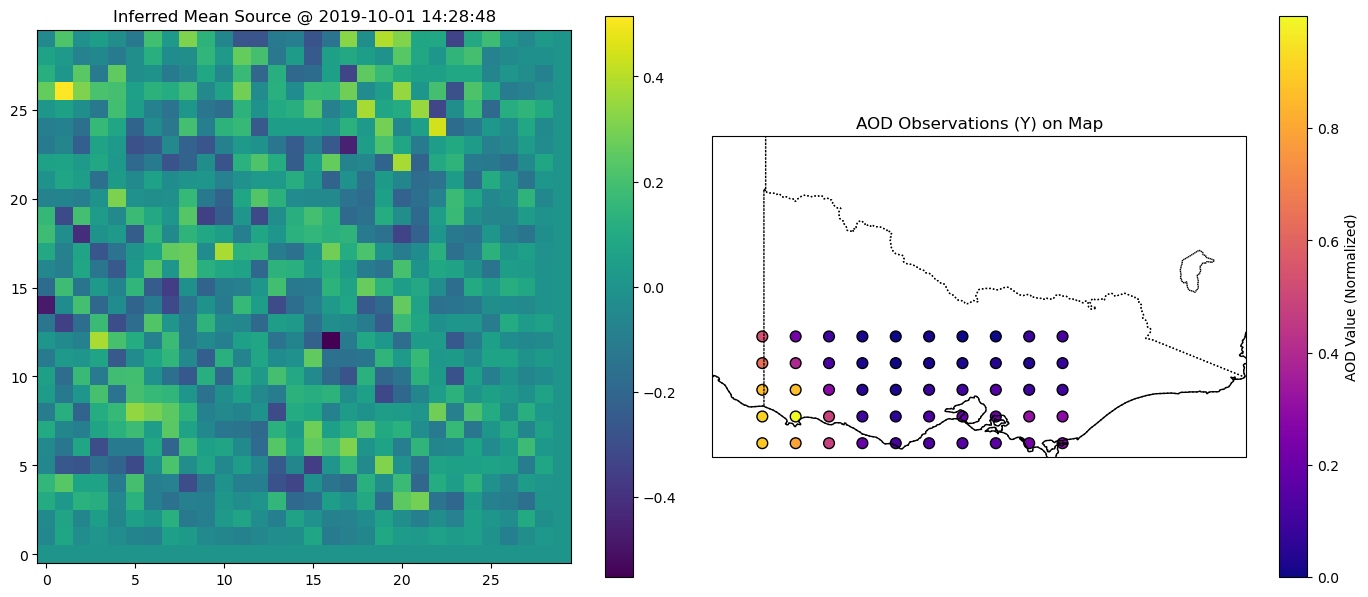

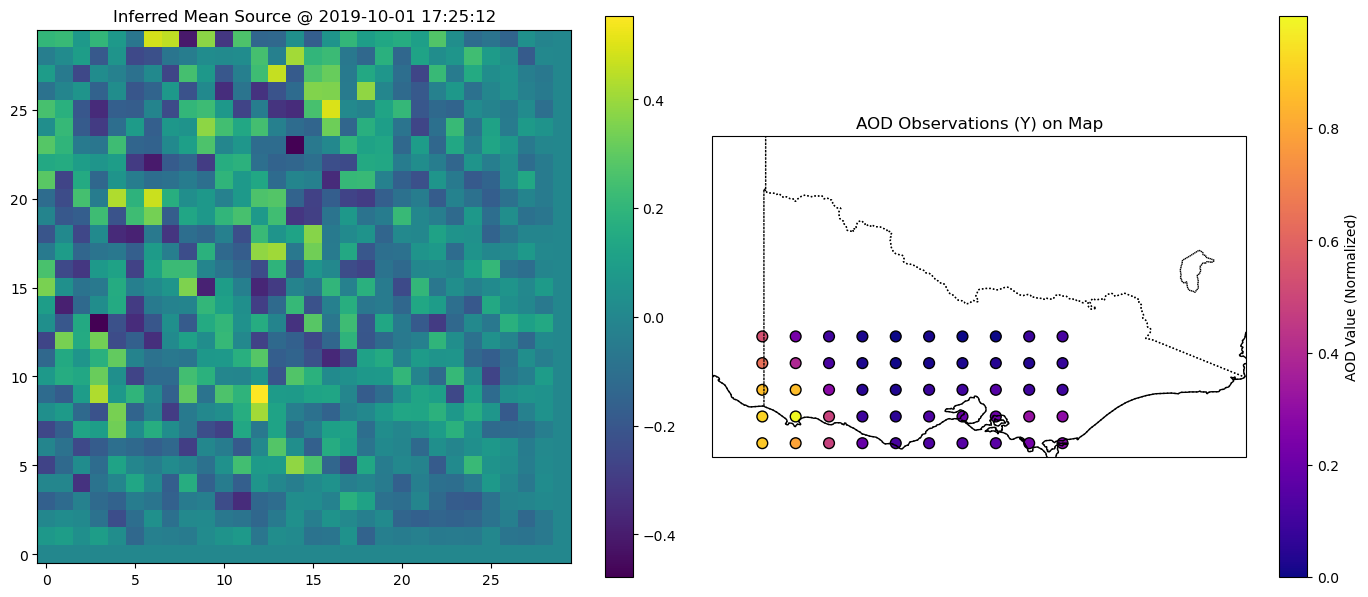

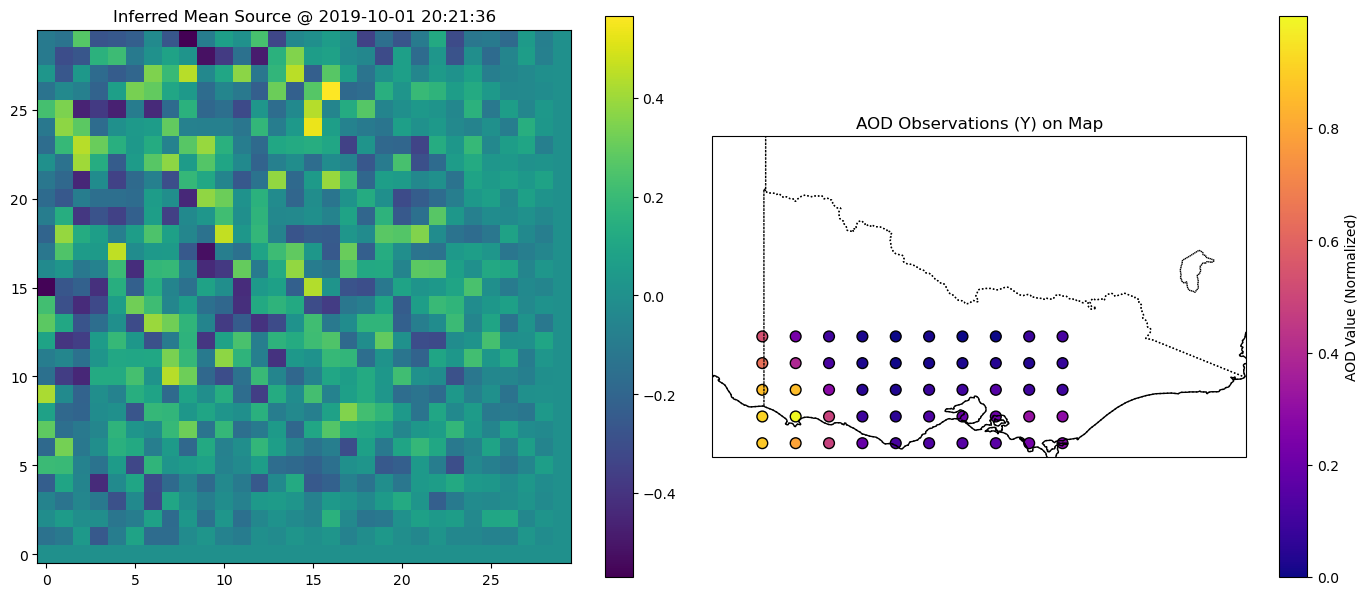

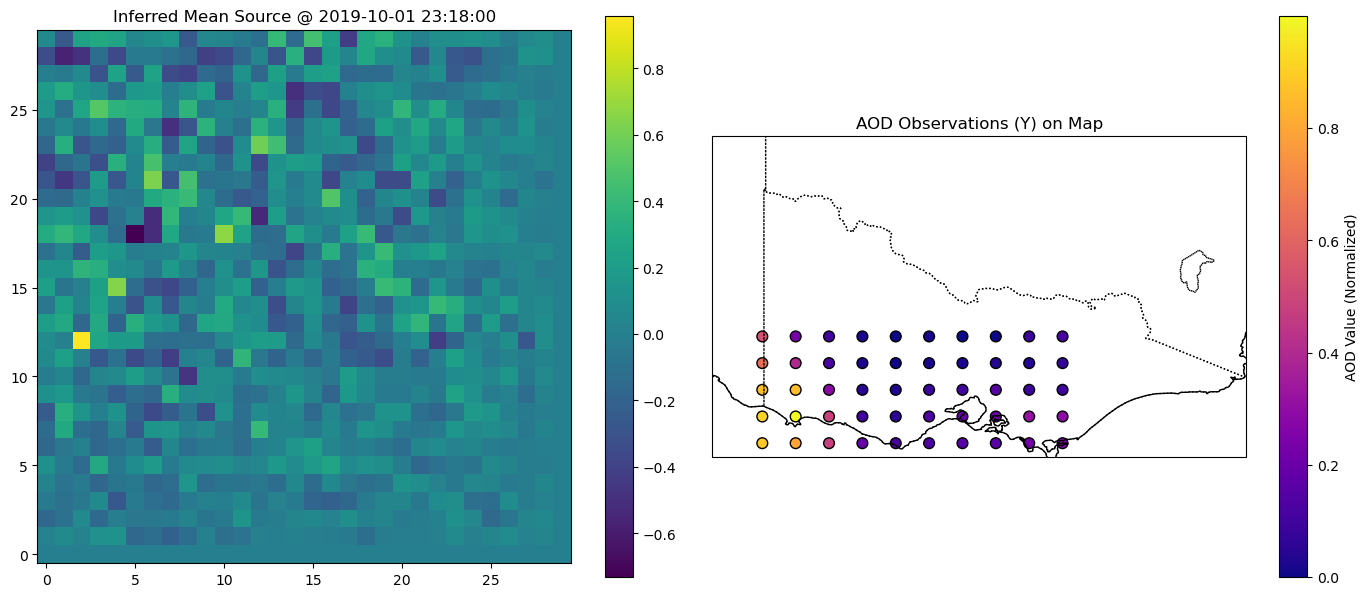

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

step_interval = int(10800 / dt_seconds)

for t_index in range(0, res[0], step_interval):
    # === Time Calculation ===
    real_seconds = boundary[0][0] + t_index * dt_seconds
    real_datetime = base_time + timedelta(seconds=int(real_seconds))
    timestamp_label = real_datetime.strftime("%Y-%m-%d %H:%M:%S")
    
    # === Plotting ===
    fig = plt.figure(figsize=(14, 6))
    
    # === Mean Inferred Source ===
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(f"Inferred Mean Source @ {timestamp_label}")
    im = ax1.imshow(sourcemean[t_index], origin='lower', cmap='viridis')
    fig.colorbar(im, ax=ax1, orientation='vertical')
    
    # === AOD on Cartopy Map ===
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_title("AOD Observations (Y) on Map")
    
    lats_Y = np.array([lat for lat, lon in sensor_latlons])
    lons_Y = np.array([lon for lat, lon in sensor_latlons])
    
    sc = ax2.scatter(lons_Y, lats_Y, c=Y, cmap='plasma', s=60, edgecolor='k', transform=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    ax2.add_feature(cfeature.STATES, linestyle=':')
    ax2.set_extent([140, 150, -39, -33])  # Adjust as needed
    fig.colorbar(sc, ax=ax2, orientation='vertical', label="AOD Value (Normalized)")
    
    plt.tight_layout()
    plt.show()


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


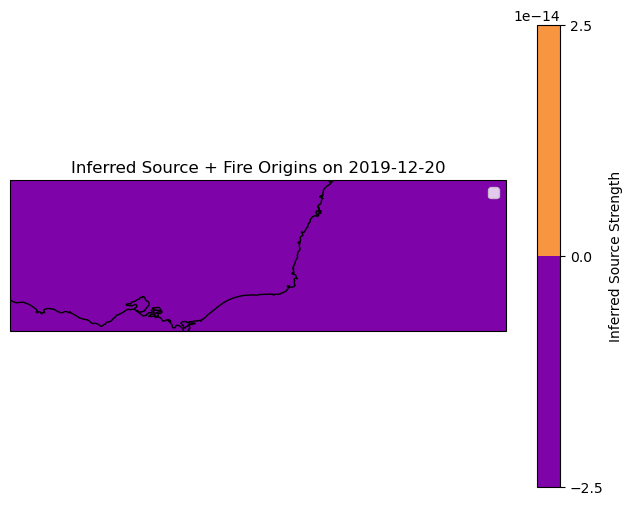

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


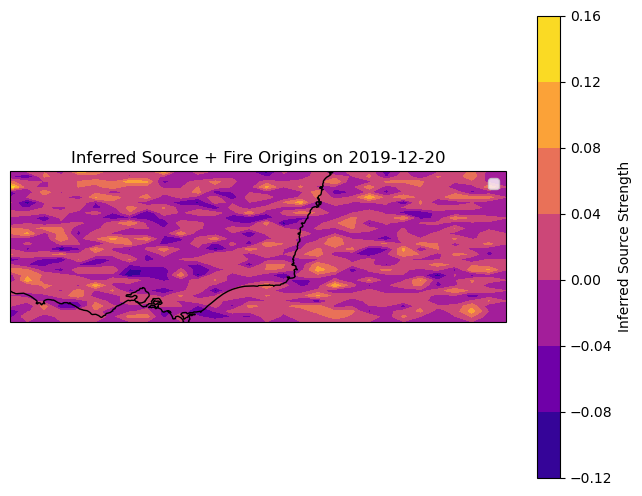

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


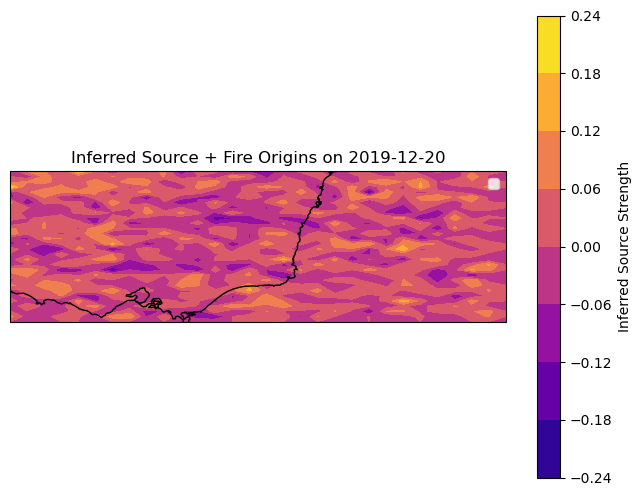

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


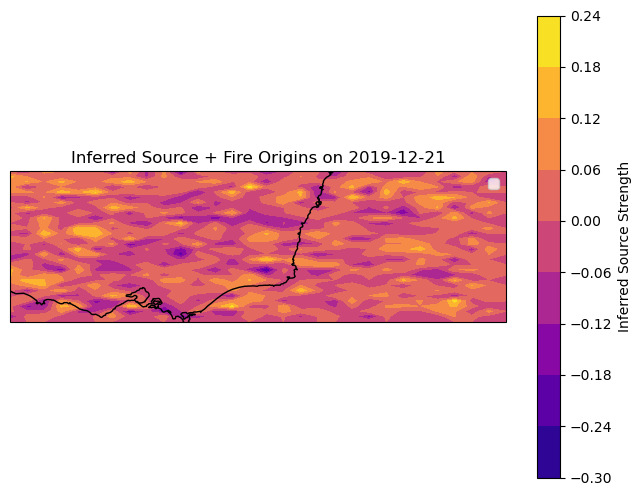

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


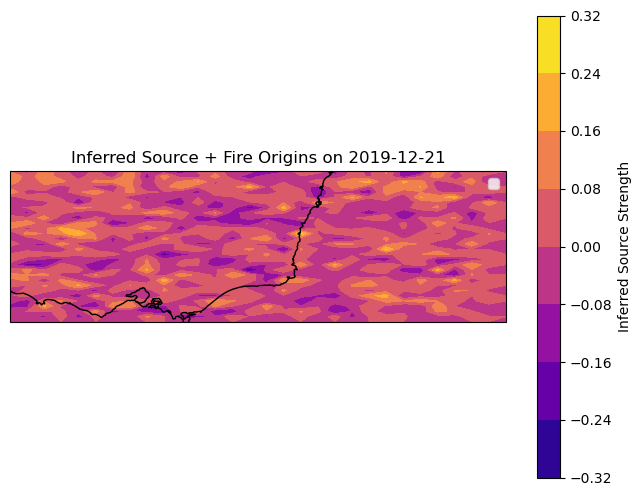

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


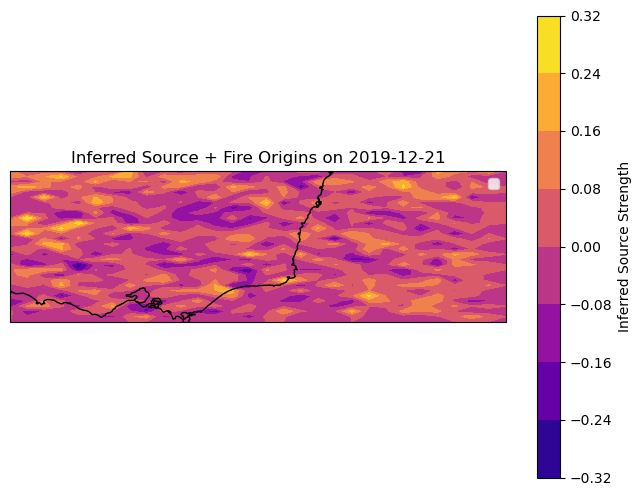

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


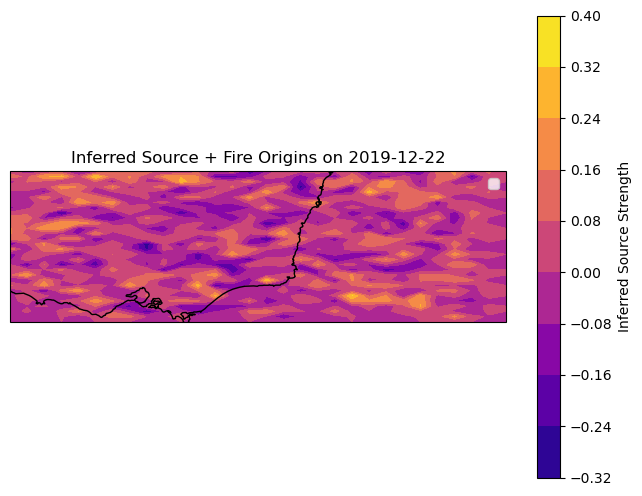

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


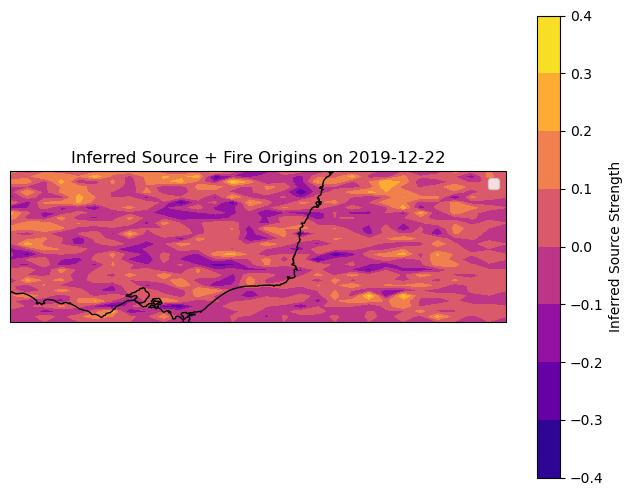

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


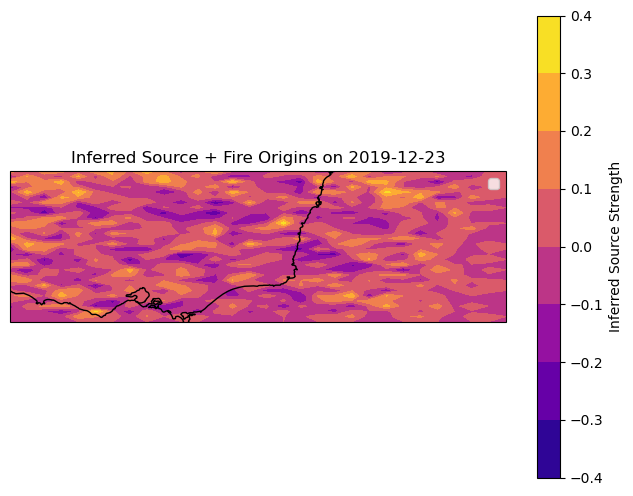

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


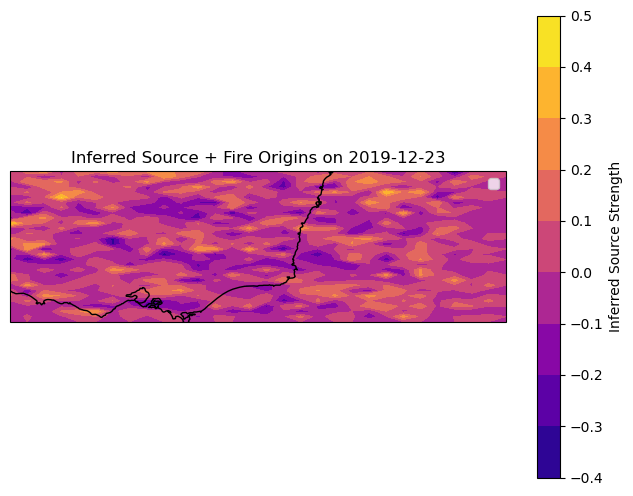

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


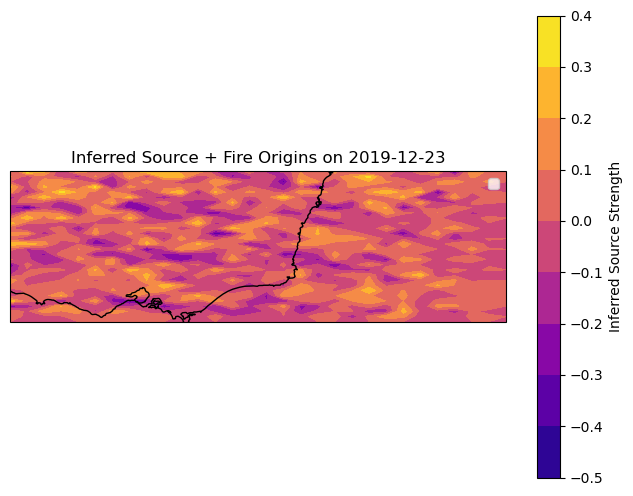

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


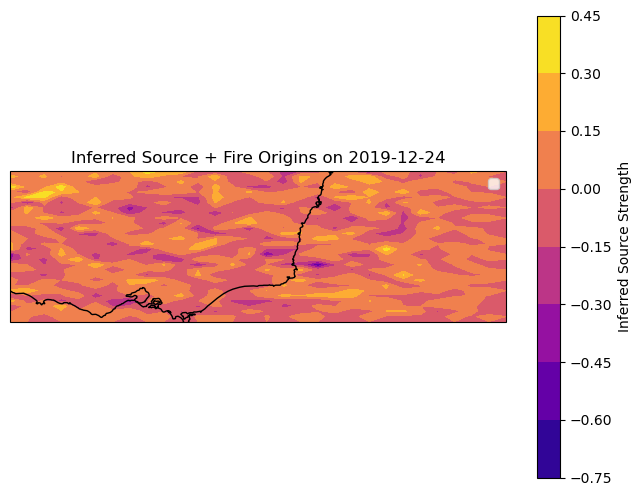

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


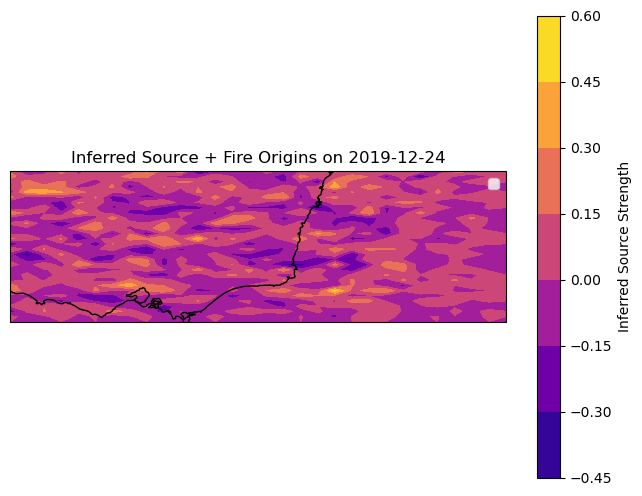

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


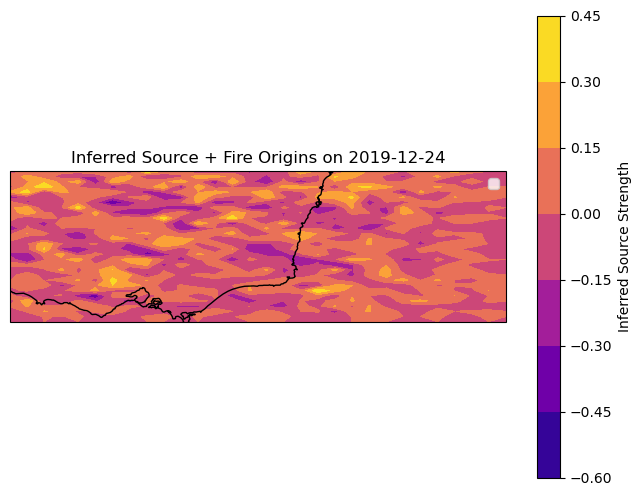

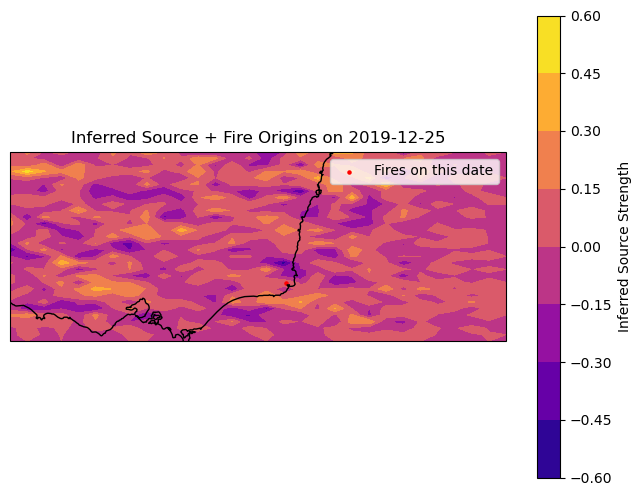

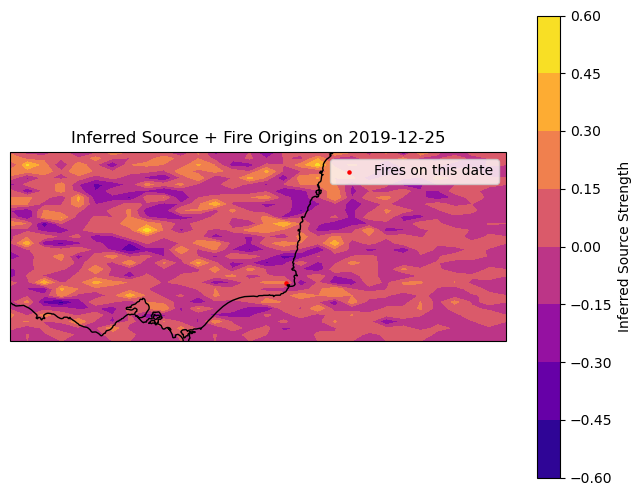

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2699844562.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


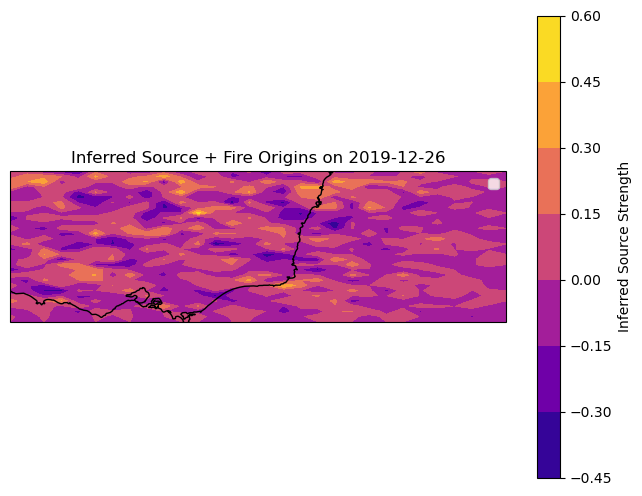

TypeError: 'module' object is not callable. Did you mean: 'datetime.datetime(...)'?

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import geopandas as gpd

import datetime




# Set base times
source_base_time = datetime.datetime(2019, 10, 1, 0, 0)
aod_base_time = datetime(2019, 10, 1, 0, 0)  # Confirmed from AOD metadata

# Time info
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
source_times = [source_base_time + timedelta(seconds=boundary[0][0] + i * dt_seconds) for i in range(res[0])]
aod_timestamps = [aod_base_time + timedelta(minutes=float(m)) for m in aod_times]

# Grids
lat_bins = np.linspace(-39, -34, sourcemean.shape[1])
lon_bins = np.linspace(140.5, 157, sourcemean.shape[2])
lon_grid, lat_grid = np.meshgrid(lons, lats)  # from your AOD dataset

# Plot every 3-hour step in sourcemean
for t_index in range(0, res[0], int(10800 // dt_seconds)):  # 3-hour step

    source_time = source_times[t_index]

    # Find closest AOD slice by time
    time_diffs = [abs((source_time - aod_time).total_seconds()) for aod_time in aod_timestamps]
    aod_index = np.argmin(time_diffs)
    aod_time = aod_timestamps[aod_index]
    aod_slice = aod_data[aod_index]  # ✅ this line was missing before

    # Normalize AOD slice for better contrast
    aod_slice = aod_slice - np.nanmin(aod_slice)
    aod_slice = aod_slice / (np.nanmax(aod_slice) + 1e-6)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # === Left: Inferred Source ===
    ax1 = axes[0]
    ax1.set_extent([140.5, 157, -39, -34])
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_feature(cfeature.LAND, facecolor='lightgray')
    ax1.set_title(f"Inferred Source @ {source_time.strftime('%Y-%m-%d %H:%M')}")
    cf1 = ax1.contourf(lon_bins, lat_bins, sourcemean[t_index], cmap='plasma', transform=ccrs.PlateCarree())
    fig.colorbar(cf1, ax=ax1, orientation='vertical', label='Inferred Source Strength')

    # === Right: AOD Observation ===
    ax2 = axes[1]
    ax2.set_extent([140.5, 157, -39, -34])
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS)
    ax2.add_feature(cfeature.LAND, facecolor='lightgray')
    ax2.set_title(f"AODANA @ {aod_time.strftime('%Y-%m-%d %H:%M')}")
    cf2 = ax2.contourf(lon_grid, lat_grid, aod_slice, levels=np.linspace(0.001, 0.18, 30), cmap='plasma', transform=ccrs.PlateCarree())
    fig.colorbar(cf2, ax=ax2, orientation='vertical', label='AODANA')

    plt.tight_layout()
    plt.show()


In [16]:
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191001.nc4"
dataset = Dataset(file_path, 'r')

aod_times = dataset.variables['time'][:]  # Shape: (8,)
# Time units should be: "minutes since 2019-10-01 00:00:00"
time_units = dataset.variables['time'].units
base_time = datetime(2019, 10, 1, 0, 0)

lats = dataset.variables['lat'][:]  # (361,)
lons = dataset.variables['lon'][:]  # (576,)
aod_data = dataset.variables['AODANA'][:]  # shape (8, 361, 576)



C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2372863685.py:4: RuntimeWarning: invalid value encountered in cast
  aod_times = dataset.variables['time'][:]  # Shape: (8,)
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_37972\2372863685.py:4: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = dataset.variables['time'][:]  # Shape: (8,)


In [29]:
print("AOD shape:", aod_data.shape)
print("AOD min:", np.nanmin(aod_data))
print("AOD max:", np.nanmax(aod_data))
print("Unique values in selected slice:", np.unique(aod_slice))
print(dataset.variables['AODANA']._FillValue)
print("Lat range in AOD:", lats.min(), lats.max())
print("Lon range in AOD:", lons.min(), lons.max())
print("aod_slice shape:", aod_slice.shape)
print("lon_grid shape:", lon_grid.shape)
print("lat_grid shape:", lat_grid.shape)



AOD shape: (8, 361, 576)
AOD min: 0.0026594934
AOD max: 5.27701
Unique values in selected slice: [0.0 1.0495667083887383e-05 1.3503277841664385e-05 ... 0.766528844833374
 0.8030286431312561 0.9999997615814209]
1000000000000000.0
Lat range in AOD: -90.0 90.0
Lon range in AOD: -180.0 179.375
aod_slice shape: (361, 576)
lon_grid shape: (361, 576)
lat_grid shape: (361, 576)


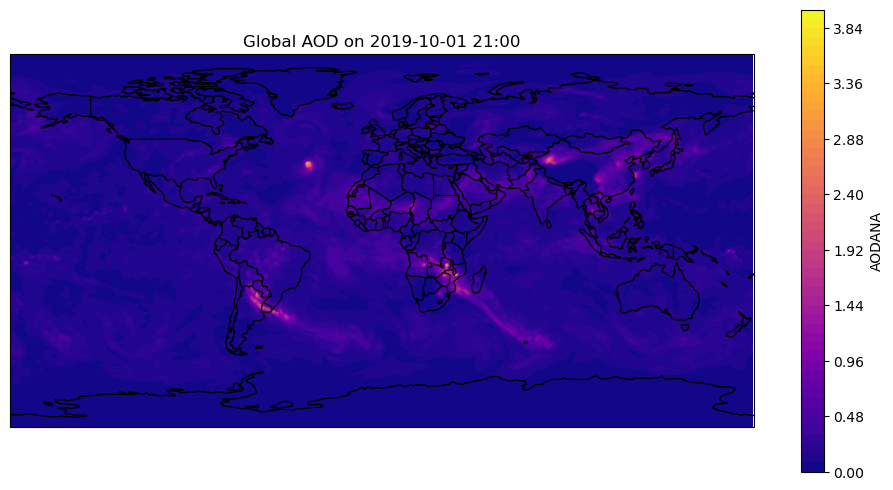

In [24]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
cf = ax.contourf(lon_grid, lat_grid, aod_slice, transform=ccrs.PlateCarree(), cmap='plasma', levels=50)
plt.colorbar(cf, ax=ax, label='AODANA')
plt.title(f"Global AOD on {aod_time.strftime('%Y-%m-%d %H:%M')}")
plt.show()
